In [1]:
import numpy as np
import qutip as qt
import scipy as sp
from scipy import linalg
import matplotlib
import matplotlib.pylab as plt
import krotov
import os.path
import random
from matplotlib import rc
from cycler import cycler
from cmt import *

rc('font',**{'family':'serif','serif':['Computer Modern'], 'size':25})
rc('text', usetex=True)

In [2]:
e = 1.6e-19 #coulomb
h = 6.63e-34 *1e12/ e #eV ps
hbar = 1
hbar_eV = 6.582e-16 * 1e12 #eV ps
c = 3e8 * 1e-10 # cm/ps
k = 1.38e-23 # [J K^-1]
mass_ps = 1.022e6 # eV/ c^2 
wavelength = 243e-7 #cm
wavenumber = 2*np.pi/wavelength
momentum_per_photon = hbar_eV*wavenumber #eV ps cm^-1
velocity_change_per_photon = momentum_per_photon / mass_ps *c**2 #  cm/ps
energy_splitting =  h*c/wavelength

In [25]:
class laser:
    def __init__(self,pulse_kwargs):
        # Initialising time-variables
        self.omega0 = energy_splitting / hbar / hbar_eV# radians ps^-1
        self.endTime =  20 #ps 
        self.binwidth = 2*np.pi/self.omega0*100
        self.N_time = int(self.endTime/self.binwidth)
        self.tlist = np.linspace(0,self.endTime,self.N_time)
        self.tcentre = int(self.endTime/2) #ps
        self.tlist_centre = np.full(self.N_time,self.tcentre)
        self.detuning = pulse_kwargs["detuning"]
        self.chirp = pulse_kwargs["chirp"]
        self.rabi0= pulse_kwargs["rabi0"]
        self.pulse_duration = pulse_kwargs["pulse_duration"]
        self.direction = pulse_kwargs["direction"]
        self.label = pulse_kwargs["label"]

        self.rabi = lambda t, args: self.rabi0 * np.exp(-4*np.log(2)*(t-self.tcentre)**2/self.pulse_duration**2)
        
class Ps_system:
    def __init__(self):
        self.T = 300 #K temperature of cloud
        self.m = 2*9.1e-31 #kg
        self.std_deviation = np.sqrt(k*self.T/self.m) #standard deviation of gaussian
        self.amplitude = np.sqrt(self.m/(2*np.pi*k*self.T))

        self.N_bins = 267 #calculated such that 1 bin is the equivalent of 1 unit of photon momentum for Ps

        self.velocity_bins,self.dv = np.linspace(-2e-5,2e-5,self.N_bins,retstep=True) #cm/ps

        # Assume Maxwell-Boltzmann distribution
        self.N_atoms = int(1e5)
        self.initial_MB = np.zeros(self.N_bins)
        for i in range(self.N_bins-1):
            self.initial_MB[i] = int(sp.integrate.quad(lambda v: self.amplitude*np.exp(-v**2/(2*self.std_deviation**2))*1e5,self.velocity_bins[i]*1e10,self.velocity_bins[i+1]*1e10)[0])

        self.laserDict = dict()

    # get initial Maxwell-Boltzmann distribution
    def get_initial_MBplot(self):
        fig,ax = plt.subplots()
        ax.plot(self.velocity_bins,self.initial_MB)
        ax.set_xlabel("velocities [cm/ps]")
        ax.set_ylabel("Number of Ps")
        
        return fig,ax
    

    def get_ground(self):
        return np.asarray([np.abs(self.states[2*i,2*i]) for i in range(self.N_bins)])
    
    
    def get_excited(self):
        return np.asarray([np.abs(self.states[2*i+1,2*i+1]) for i in range(self.N_bins)])


    # instantiate a new object with name given by label
    def init_pulse(self,pulse_kwargs):
        laserLabel = pulse_kwargs["label"]
        laserObj = laser(pulse_kwargs)
        self.laserDict[laserLabel] = laserObj


    # Initialise states in ground
    def init_states_ground(self):
        vel_DM = qt.Qobj(np.sqrt(self.initial_MB))*qt.Qobj(np.sqrt(self.initial_MB)).dag() # density matrix    
        self.states = qt.tensor(vel_DM,qt.Qobj([[1,0],[0,0]])) # density matrix, composite of g/e space and vel space


    # Initialise states in excited
    def init_states_excited(self):
        vel_DM = qt.Qobj(np.sqrt(self.initial_MB))*qt.Qobj(np.sqrt(self.initial_MB)).dag() # density matrix    
        self.states = qt.tensor(vel_DM,qt.Qobj([[0,0],[0,1]])) # density matrix, composite of g/e space and vel space

    # Initialise desymmetrized states
    #def init_states_desymmetrized(self):


    def evolve_noCMT(self,laserLabel):
        laser = self.laserDict[laserLabel]

        tensor1 = qt.tensor(qt.qeye(self.N_bins),qt.Qobj([[0,0],[0,1]]))
        tensorn = qt.tensor(qt.num(self.N_bins,offset=1),qt.Qobj([[0,0],[0,1]]))
        tensord = qt.tensor(qt.qeye(self.N_bins),qt.sigmax())

        H0 = hbar*(laser.detuning+laser.direction*self.velocity_bins[0]/c*(laser.omega0+laser.detuning))*tensor1
        Hv0 = hbar * self.dv * (laser.omega0 + laser.detuning) * laser.direction/c * tensorn
        H_v_chirp = hbar*laser.chirp*laser.direction*self.dv/c*tensorn
        H_chirp = hbar * laser.chirp*(1+laser.direction*self.velocity_bins[0]/c)*tensor1
        H_transition = 0.5*hbar*tensord

        H = [H0,Hv0,[H_chirp+H_v_chirp,laser.tlist-laser.tlist_centre],[H_transition,laser.rabi]]
        
        opts = qt.Options(store_states=True)
        result = qt.mesolve(H, self.states,laser.tlist, options = opts)
        self.states = result.states[-1]
        
    # assume Hamiltonian only affects the even n ground states and odd n excited states
    # just treat the system as if it did not have ground/excited states... only velocity states
    def init_FCMT(self):
        pops = qt.Qobj([pops[2*i] for i in range(self.N_bins)])
        self.states = pops*pops.dag() # 2n'th element is ground, (2n+1)'th element is excited, for n = 0,1,2,...,N_bins
    
    def evolve_CMT(self,laserLabel):
        kinetic_energy = qt.num(qt.num(self.N_bins))

        laser = self.laserDict[laserLabel]
        H0_g = hbar*laser.omega0 + self.velocity_bins[0]
        H0_e = hbar*(laser.detuning+laser.direction*self.velocity_bins[0]/c*(laser.omega0+laser.detuning))
    #use for iterating through pulses for cooling
    #def __iter__(self):
    #def __next__(self):
    

In [26]:
system = Ps_system()

flip_pulse = {"label":"flip", "rabi0" : 2*np.pi*(1000e-3), "detuning": 0,"chirp" : 2*np.pi*(200e-3),"pulse_duration" : 10 ,"direction":+1}
system.init_pulse(flip_pulse)
system.init_states_ground()
system.evolve_noCMT(flip_pulse["label"])




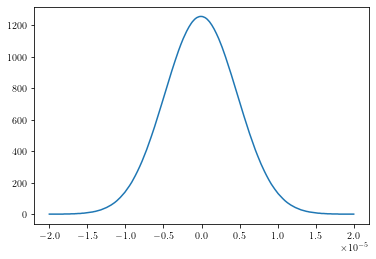

In [29]:
excited = system.get_excited()
plt.plot(system.velocity_bins,excited)
#plt.hlines(1,-2e-5,2e-5,ls="dashed",color="black")
plt.show()

In [4]:
print(qt.num(267))

Quantum object: dims = [[267], [267]], shape = (267, 267), type = oper, isherm = True
Qobj data =
[[  0.   0.   0. ...   0.   0.   0.]
 [  0.   1.   0. ...   0.   0.   0.]
 [  0.   0.   2. ...   0.   0.   0.]
 ...
 [  0.   0.   0. ... 264.   0.   0.]
 [  0.   0.   0. ...   0. 265.   0.]
 [  0.   0.   0. ...   0.   0. 266.]]
